In [230]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("ggplot")
from pylab import rcParams
import seaborn as sns
%matplotlib inline
np.random.seed(27)
rcParams['figure.figsize'] = 10, 6
sns.set(style="darkgrid")
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
users = pd.read_csv("./data/profiles.csv")

# total_rows = 59946

#total_columns = 31


In [3]:

# rows with NA values for "drugs" columns were set out as test_data on which predictions will be made later
# don't touch

users_test = users[users["drugs"].isna()]

# 14080 rows with y as NA


In [183]:
# columns without nans for y i.e drugs columns is used to train the model and validate

users_no_na = users[users["drugs"].notna()]


# 45866 rows left 


In [186]:
#trying model with fewer features

X_whole_sample = users_no_na[["age", "body_type", "drinks", "education", "drugs"]]

X_whole_sample["drugs"] = X_whole_sample["drugs"].replace(["never","sometimes", "often"], [0,1,1])

X_whole_sample = X_whole_sample.dropna(axis = 0)

# left with 37193 after getting rid of nans

X_sample = X_whole_sample.loc[:,X_whole_sample.columns != "drugs"]

y_sample = X_whole_sample.loc[:,X_whole_sample.columns == "drugs"]

X_whole_sample

/Users/shwetasharma1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,age,body_type,drinks,education,drugs
0,22,a little extra,socially,working on college/university,0
1,35,average,often,working on space camp,1
4,29,athletic,socially,graduated from college/university,0
6,32,fit,socially,graduated from college/university,0
7,31,average,socially,graduated from college/university,0
...,...,...,...,...,...
59931,24,fit,rarely,graduated from college/university,0
59936,25,average,socially,graduated from college/university,0
59942,24,fit,often,working on college/university,1
59943,42,average,not at all,graduated from masters program,0


<Figure size 432x288 with 0 Axes>

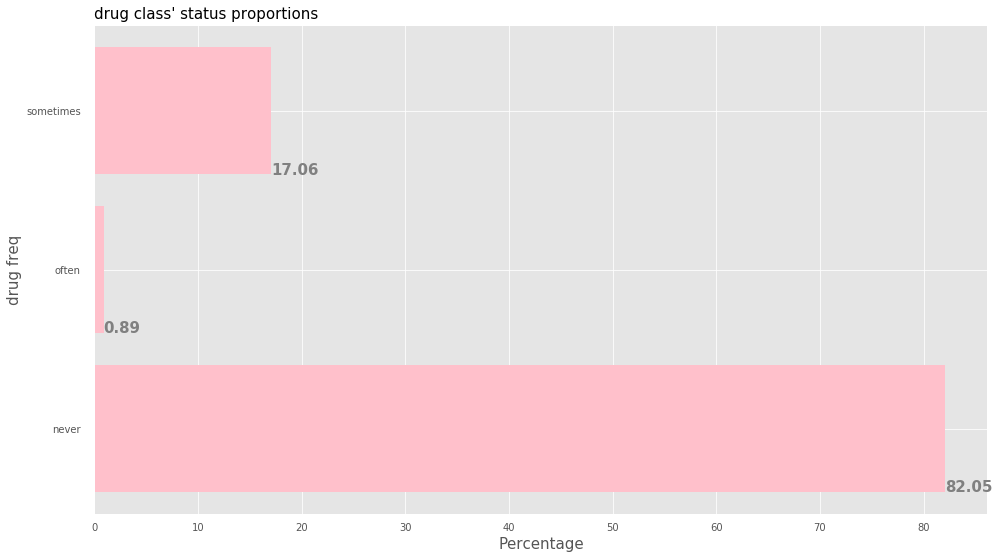

In [6]:
drug_proportion = X_whole_sample.groupby(["drugs"]).size().reset_index(name = "counts")

x = np.array(drug_proportion.iloc[:,0])
y = np.array(drug_proportion.iloc[:,1])
total = y.sum()

fig = plt.figure()
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(x, y*100/total, color="pink")
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10)
for i in ax.patches: 
    plt.text(i.get_width(), i.get_y(),  
             str(round((i.get_width()), 2)), 
             fontsize = 15, fontweight ='bold', 
             color ='grey')
    
ax.set_title("drug class' status proportions", 
             loc ='left', fontsize =15) 
ax.set_ylabel("drug freq", fontsize =15)
ax.set_xlabel("Percentage", fontsize =15)
fig.savefig('drug_perc.png', bbox_inches='tight')

#imbalanced classes, heavy on never
# accuracy metric can be misleading and therefore should be used cautiously.

high recall + high precision : the class is perfectly handled by the model
low recall + high precision : the model can’t detect the class well but is highly trustable when it does
high recall + low precision : the class is well detected but the model also include points of other classes in it
low recall + low precision : the class is poorly handled by the model

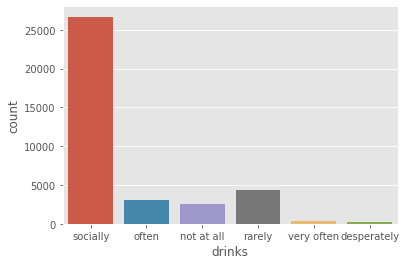

In [62]:
sns.countplot(data = X_sample, x = X_sample["drinks"])

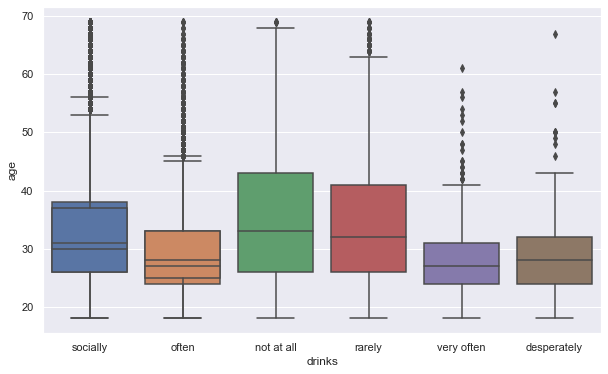

In [187]:
sns.boxplot(data = X_whole_sample, x=X_whole_sample["drugs"], y= X_sample["age"])


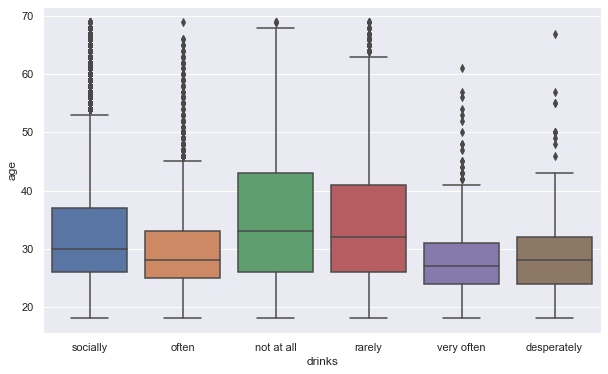

In [216]:
sns.boxplot(data = X_whole_sample, x=X_whole_sample["drinks"], y= X_sample["age"])

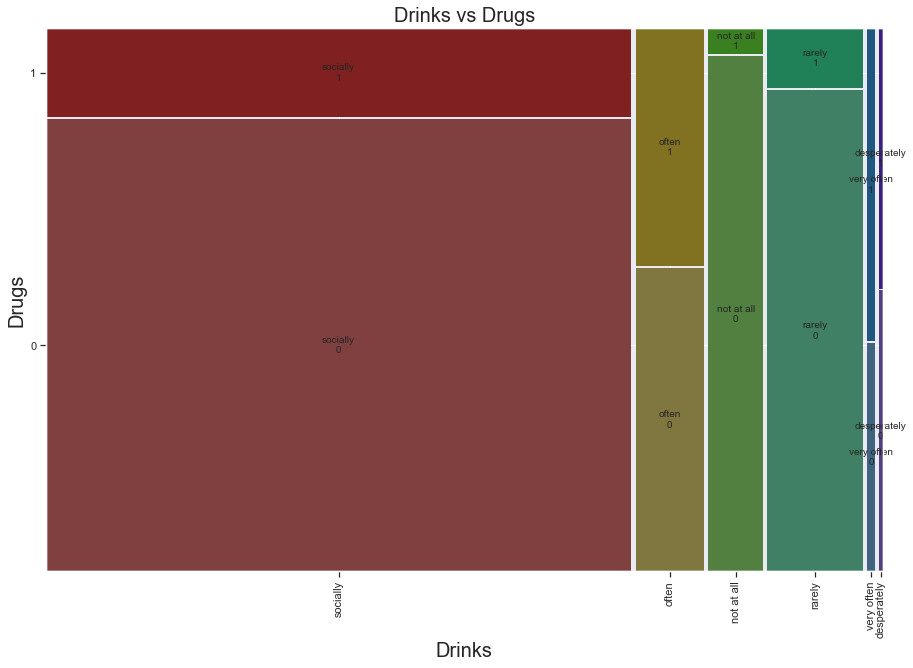

In [217]:
from statsmodels.graphics.mosaicplot import mosaic
fig, ax = plt.subplots(figsize = (15,10))
data = pd.DataFrame({'drinks': X_whole_sample["drinks"], 'drugs': X_whole_sample["drugs"]})
mosaic(data, ['drinks', 'drugs'], title='Drinks vs Drugs', ax= ax )
ax.set_title('Drinks vs Drugs', fontsize=20)
ax.set_xlabel("Drinks", fontsize=20)
ax.set_ylabel("Drugs", fontsize=20)
for tick in ax.get_xticklabels():
    tick.set_rotation(90);

In [7]:
# 12 body types
# 6 classes in drinks
# 33 unique classes for education


In [8]:
X_sample_dummified = pd.get_dummies(X_sample)
X_sample_dummified

,age,body_type_a little extra,body_type_athletic,body_type_average,body_type_curvy,body_type_fit,body_type_full figured,body_type_jacked,body_type_overweight,body_type_rather not say,...,education_space camp,education_two-year college,education_working on college/university,education_working on high school,education_working on law school,education_working on masters program,education_working on med school,education_working on ph.d program,education_working on space camp,education_working on two-year college
0,22,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,35,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,29,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,32,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,31,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59931,24,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59936,25,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59942,24,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
59943,42,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


0    30515
1     6678
Name: drugs, dtype: int64


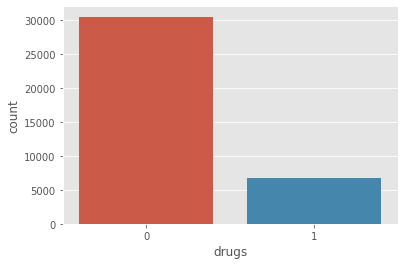

In [114]:

## Split first to avoid leakage

X_train, X_test, y_train, y_test = train_test_split(X_sample_dummified, y_sample, test_size = .10, random_state=1)


ax = sns.countplot(x = X_whole_sample["drugs"] , data = X_whole_sample)
print(X_whole_sample["drugs"].value_counts())


In [153]:
def generate_model_report(y_actual, y_predicted):
    print('Accuracy: %.3f' % accuracy_score(y_actual, y_predicted))
    print('Precision: %.3f' % precision_score(y_actual, y_predicted))
    print( 'Recall: %.3f' % recall_score(y_actual, y_predicted))
    print('F1 score: %.3f' % f1_score(y_actual, y_predicted))


In [154]:
def generate_auc_roc_curve(model, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

In [155]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train);

/Users/shwetasharma1/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [156]:
y_preds = model.predict(X_test)

pd.crosstab(y_preds, y_test["drugs"], rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,3025,567
1,52,76


In [157]:
generate_model_report(y_test, y_preds)
# high accuracy but other metrics have low value due to unbalanced data

Accuracy: 0.834
Precision: 0.594
Recall: 0.118
F1 score: 0.197


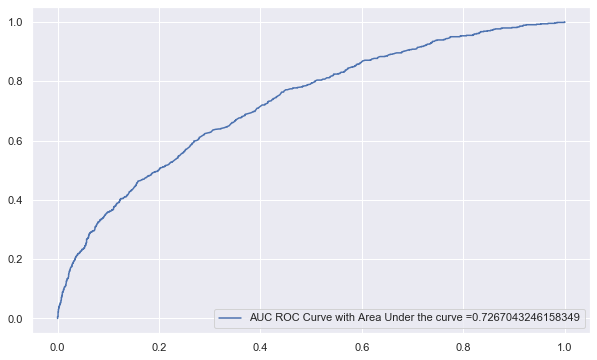

In [158]:
generate_auc_roc_curve(model, X_test, y_test)

## UNDERSAMPLING

In [218]:
# Class count
count_class_0, count_class_1 = X_whole_sample['drugs'].value_counts()

df_class_0 = X_whole_sample[X_whole_sample['drugs'] == 0]
df_class_1 = X_whole_sample[X_whole_sample['drugs'] == 1]

Random under-sampling:
1    6678
0    6678
Name: drugs, dtype: int64


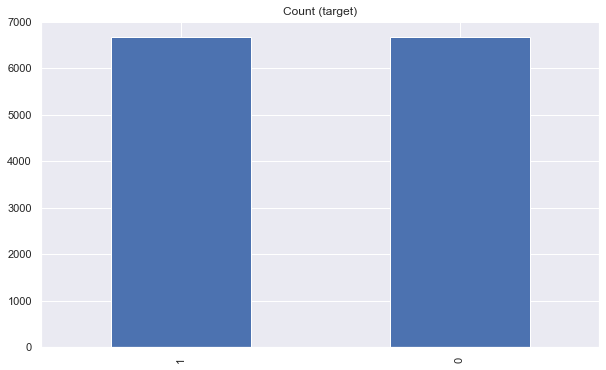

In [159]:


df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under["drugs"].value_counts())

df_test_under["drugs"].value_counts().plot(kind='bar', title='Count (target)')

In [160]:
df_test_under = pd.get_dummies(df_test_under)

In [163]:
X_under = df_test_under.loc[:, df_test_under.columns!= "drugs"]
Y_under = df_test_under.loc[:, df_test_under.columns=="drugs"]
X_under_train, X_under_test, Y_under_train, Y_under_test = train_test_split(X_under, Y_under["drugs"], test_size=0.10, random_state=1)
model = LogisticRegression(max_iter=600).fit(X_under_train, Y_under_train)
Y_under_preds = model.predict(X_under_test)

In [164]:
generate_model_report(Y_under_test, Y_under_preds)

Accuracy: 0.650
Precision: 0.657
Recall: 0.620
F1 score: 0.638


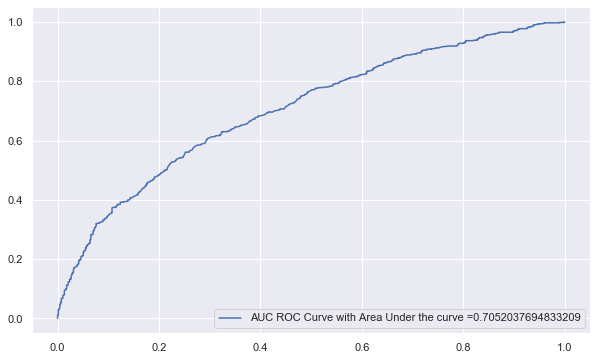

In [165]:
generate_auc_roc_curve(model, X_under_test, Y_under_test)

## OVERSAMPLING

Random over-sampling:
1    30515
0    30515
Name: drugs, dtype: int64


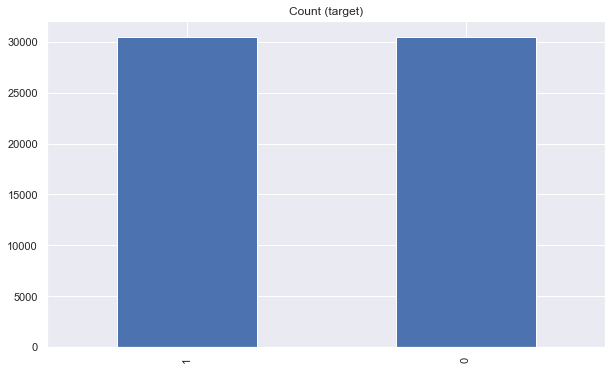

In [220]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over["drugs"].value_counts())

df_test_over["drugs"].value_counts().plot(kind='bar', title='Count (target)');

In [222]:
df_test_over = pd.get_dummies(df_test_over)

In [223]:
X_over = df_test_over.loc[:, df_test_over.columns != "drugs"]
Y_over = df_test_over.loc[:, df_test_over.columns=="drugs"]
X_over_train, X_over_test, Y_over_train, Y_over_test = train_test_split(X_over, Y_over["drugs"], test_size=0.10, random_state=1)
model = LogisticRegression(max_iter=600).fit(X_over_train, Y_over_train)
Y_over_preds = model.predict(X_over_test)

In [224]:
generate_model_report(Y_over_test, Y_over_preds)

Accuracy: 0.656
Precision: 0.651
Recall: 0.628
F1 score: 0.639


## SMOTE

In [175]:
sm = SMOTE(random_state=12, sampling_strategy=1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train["drugs"])

In [178]:
model = LogisticRegression(max_iter = 1000).fit(X_train_res, y_train_res)

In [179]:
Y_smot_preds = clf.predict(X_test)

In [181]:
generate_model_report(y_test, Y_smot_preds)

Accuracy: 0.677
Precision: 0.298
Recall: 0.642
F1 score: 0.407


In [274]:
def run_model(estimator, X, y):
    kf = KFold(n_splits=10, shuffle=True)
    
    acc = []
    for train_idx, test_idx in kf.split(X):
        X_train = X[train_idx]
        y_train = y[train_idx]
         
        
        X_test = X[test_idx]
        y_test = y[test_idx]

        # data prep
        
        estimator.fit(X_train, y_train)
        y_preds = estimator.predict(X_test)
        acc.append(accuracy_score(y_test, y_preds))
#         print(estimator.__class__.__name__)
#         generate_model_report(y_test, y_preds)
#         print("\n\n")
        
    plt.plot(range(0, 10), acc, label=estimator.__class__.__name__)

In [275]:
estimators = [LogisticRegression(max_iter=1000), RandomForestClassifier(), GradientBoostingClassifier()]

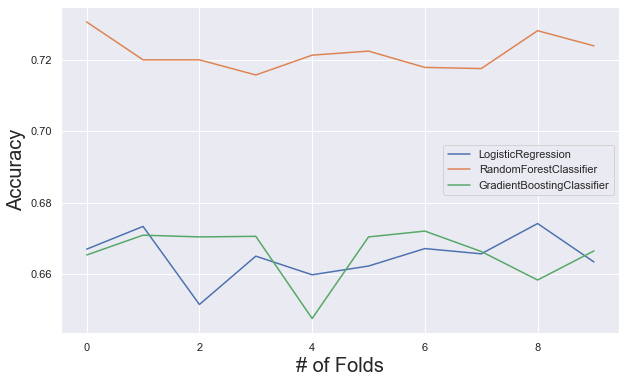

In [277]:
for estimator in estimators:
    run_model(estimator, X_over.values, Y_over["drugs"].values)
    
    
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('# of Folds', fontsize=20)
plt.legend()

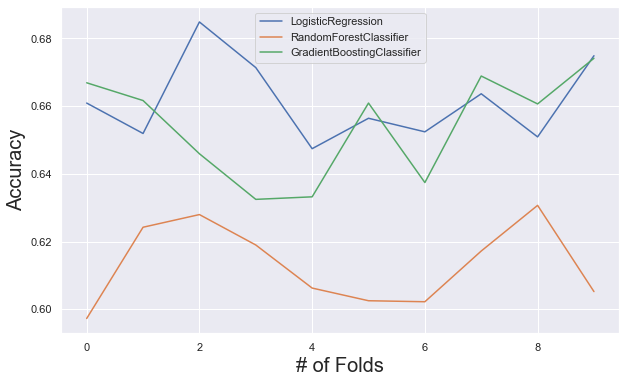

In [278]:
for estimator in estimators:
    run_model(estimator, X_under.values, Y_under["drugs"].values)
    
    
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('# of Folds', fontsize=20)
plt.legend()